![logo](https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/img/LogoLine_horizon_C3S.png?raw=1)

<br>

# Plot an Ensemble of CMIP6 Climate Projections

### About

This notebook provides a practical introduction on how to access and process [CMIP6 global climate projections](https://cds.climate.copernicus.eu/datasets/projections-cmip6?tab=overview) data available in the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S). The workflow shows how to compute and visualize the output of an ensemble of models for the annual global average temperature between 1850 to 2100. You will use the `historical` experiment for the temporal period 1850 to 2014 and the three scenarios `SSP1-2.6`, `SSP2-4.5` and `SSP5-8.5` for the period from 2015 to 2100.

For the sake of simplicity, and to facilitate data download, the tutorial will make use of some of the coarser resolution models that have a smaller data size. It is nevertheless only a choice for this exercise and not a recommendation (since ideally all models, including those with highest resolution, should be used). Many more models are available on the CDS, and when calculating an ensemble of models, it is best practice to use as many as possible for a more reliable output. See [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-Models,gridsandpressurelevels) a full list of models included in the CDS-CMIP6 dataset.

Learn [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections) more about CMIP6 global climate projections and the CMIP6 experiments in the CDS.


The notebook has the following outline:

1. Request data from the CDS programmatically with the CDS API
2. Unzip the downloaded data files
3. Load and prepare CMIP6 data for one model and one experiment
4. Load and prepare CMIP6 data for all models and experiments
5. Visualize CMIP6 annual global average temperature between 1850 to 2100

### Data

This notebook introduces you to [CMIP6 Global climate projections](https://cds.climate.copernicus.eu/datasets/projections-cmip6?tab=overview). The datasets used in the notebook have the following specifications:

> **Data**: CMIP6 global climate projections of near-surface air temperature <br>
> **Experiments**: Historical, SSP1-2.6, SSP2-4.5, SSP5-8.5 <br>
> **Models**: 7 models from Germany, France, UK, Japan and Russia <br>
> **Temporal range**: Historical: 1850 - 2014. Scenarios: 2015 - 2100 <br>
> **Spatial coverage**: Global <br>
> **Format**: NetCDF, compressed into zip files

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=projections-cmip6.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/projections-cmip6.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/projections-cmip6.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<hr>

### Install CDS API via pip

In [1]:
!pip install cdsapi

In [3]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 76.9 MB/s eta 0:00:00


### Load libraries

In [7]:
# General libs for file paths, data extraction, etc
from glob import glob
from pathlib import Path
from os.path import basename
import zipfile # To extract zipfiles
import urllib3
urllib3.disable_warnings() # Disable warnings for data download via API

# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

<hr>

## Request data from the CDS programmatically with the CDS API

We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. The string of characters that make up your KEY include your personal User ID and CDS API key. To obtain these, first register or login to the CDS (https://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/how-to-api and copy the string of characters listed after "key:". Replace the `#########` below with this string.

In [8]:
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '78f20dcf-877b-4764-b91a-54509980fee2'

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [9]:
DATADIR = './'

The next step is then to request the data with the help of the CDS API. Below, we loop through multiple data requests. These include data for different models and scenarios. It is not possible to specify multiple models in one data request as their spatial resolution varies.

We will download monthly aggregated data. These are disseminated as netcdf files within a zip archive.

In order to loop through the various experiments and models in our data requests, we will specify them as Python 'lists' here:

In [10]:
experiments = ['historical', 'ssp126', 'ssp245', 'ssp585']

In [11]:
models = ['hadgem3_gc31_ll', 'inm_cm5_0', 'inm_cm4_8', 'ipsl_cm6a_lr',
          'miroc_es2l', 'mpi_esm1_2_lr', 'ukesm1_0_ll']

> **Note:** Note that these are a selection of the lightest models (in terms of data volume), to facilitate download for the sake of this exercise. There are many [more models available on the CDS](https://cds.climate.copernicus.eu/datasets/projections-cmip6?tab=overview).

Now we can download the data for each model and experiment sequentially. We will do this separately for the historical experiments and for the various future scenarios, given that they refer to two different time periods.

Before you run the cells below, the terms and conditions on the use of the data need to have been accepted in the CDS. You can view and accept these conditions by logging into the [CDS](https://cds.climate.copernicus.eu), searching for the dataset, then scrolling to the end of the `Download data` section.

> **Note:** For more information about data access through the Climate Data Store, please see the CDS user guide [here](https://cds.climate.copernicus.eu/user-guide).

In [11]:
# DOWNLOAD DATA FOR HISTORICAL PERIOD

c = cdsapi.Client(url=URL, key=KEY)

for j in models:
    c.retrieve(
        'projections-cmip6',
        {
            'download_format': 'zip',
            'data_format': 'netcdf_legacy',
            'temporal_resolution': 'monthly',
            'experiment': 'historical',
            'level': 'single_levels',
            'variable': 'near_surface_air_temperature',
            'model': f'{j}',
            "year": [
                "1850", "1851", "1852",
                "1853", "1854", "1855",
                "1856", "1857", "1858",
                "1859", "1860", "1861",
                "1862", "1863", "1864",
                "1865", "1866", "1867",
                "1868", "1869", "1870",
                "1871", "1872", "1873",
                "1874", "1875", "1876",
                "1877", "1878", "1879",
                "1880", "1881", "1882",
                "1883", "1884", "1885",
                "1886", "1887", "1888",
                "1889", "1890", "1891",
                "1892", "1893", "1894",
                "1895", "1896", "1897",
                "1898", "1899", "1900",
                "1901", "1902", "1903",
                "1904", "1905", "1906",
                "1907", "1908", "1909",
                "1910", "1911", "1912",
                "1913", "1914", "1915",
                "1916", "1917", "1918",
                "1919", "1920", "1921",
                "1922", "1923", "1924",
                "1925", "1926", "1927",
                "1928", "1929", "1930",
                "1931", "1932", "1933",
                "1934", "1935", "1936",
                "1937", "1938", "1939",
                "1940", "1941", "1942",
                "1943", "1944", "1945",
                "1946", "1947", "1948",
                "1949", "1950", "1951",
                "1952", "1953", "1954",
                "1955", "1956", "1957",
                "1958", "1959", "1960",
                "1961", "1962", "1963",
                "1964", "1965", "1966",
                "1967", "1968", "1969",
                "1970", "1971", "1972",
                "1973", "1974", "1975",
                "1976", "1977", "1978",
                "1979", "1980", "1981",
                "1982", "1983", "1984",
                "1985", "1986", "1987",
                "1988", "1989", "1990",
                "1991", "1992", "1993",
                "1994", "1995", "1996",
                "1997", "1998", "1999",
                "2000", "2001", "2002",
                "2003", "2004", "2005",
                "2006", "2007", "2008",
                "2009", "2010", "2011",
                "2012", "2013", "2014"
            ],
            "month": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12"
            ]
        },
        f'{DATADIR}cmip6_monthly_1850-2014_historical_{j}.zip')

2025-10-04 09:29:05,510 INFO Request ID is 2c7c0889-3768-4d77-8869-1eb26be339f2
INFO:ecmwf.datastores.legacy_client:Request ID is 2c7c0889-3768-4d77-8869-1eb26be339f2
2025-10-04 09:29:05,719 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 09:29:15,934 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 09:30:24,255 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


9a1b116bcbba86ae68ca6d31f396a798.zip:   0%|          | 0.00/103M [00:00<?, ?B/s]

2025-10-04 09:30:34,721 INFO Request ID is 9481ee99-ea58-4e4c-a3ca-8cc2d3633614
INFO:ecmwf.datastores.legacy_client:Request ID is 9481ee99-ea58-4e4c-a3ca-8cc2d3633614
2025-10-04 09:30:35,742 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 09:30:50,580 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 09:31:27,614 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


1ad29c13cd0a131a7ee76998d479763d.zip:   0%|          | 0.00/94.2M [00:00<?, ?B/s]

2025-10-04 09:31:39,390 INFO Request ID is d5f504ca-dba7-45c4-956e-9ca303d9da9c
INFO:ecmwf.datastores.legacy_client:Request ID is d5f504ca-dba7-45c4-956e-9ca303d9da9c
2025-10-04 09:31:39,577 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 09:31:47,833 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 09:32:33,810 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


91cc669ed73caf804e69b85284ad44da.zip:   0%|          | 0.00/94.3M [00:00<?, ?B/s]

2025-10-04 09:33:01,095 INFO Request ID is 2a20624d-be30-4123-9bd0-532df9b9dcd2
INFO:ecmwf.datastores.legacy_client:Request ID is 2a20624d-be30-4123-9bd0-532df9b9dcd2
2025-10-04 09:33:01,398 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 09:33:15,756 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 09:33:52,657 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


a7e009d2624c1030d5ecf8d61831037e.zip:   0%|          | 0.00/92.8M [00:00<?, ?B/s]

2025-10-04 09:34:02,085 INFO Request ID is ccef7e4e-722b-4533-825e-83133799e808
INFO:ecmwf.datastores.legacy_client:Request ID is ccef7e4e-722b-4533-825e-83133799e808
2025-10-04 09:34:02,368 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 09:34:11,449 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 09:34:53,491 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


74b1133b4afabac3738a7af1eaa1fa30.zip:   0%|          | 0.00/36.5M [00:00<?, ?B/s]

2025-10-04 09:34:58,987 INFO Request ID is d3018ad4-6c70-45c6-9297-e11c6cefa609
INFO:ecmwf.datastores.legacy_client:Request ID is d3018ad4-6c70-45c6-9297-e11c6cefa609
2025-10-04 09:34:59,207 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 09:35:13,425 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 09:35:50,198 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


ca37f5a16a73ba207028be96636d1fa0.zip:   0%|          | 0.00/58.9M [00:00<?, ?B/s]

2025-10-04 09:35:57,426 INFO Request ID is 8f41132b-daaf-4604-9559-657445306312
INFO:ecmwf.datastores.legacy_client:Request ID is 8f41132b-daaf-4604-9559-657445306312
2025-10-04 09:35:57,632 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 09:36:12,203 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 09:36:20,081 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 09:36:33,571 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 09:36:50,849 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


8b36fc93602516d671a2b729caab90b6.zip:   0%|          | 0.00/103M [00:00<?, ?B/s]

In [13]:
# DOWNLOAD DATA FOR FUTURE SCENARIOS

c = cdsapi.Client(url=URL, key=KEY)

for i in experiments[1:]:
    for j in models:
        c.retrieve(
            'projections-cmip6',
            {
                'download_format': 'zip',
                'data_format': 'netcdf_legacy',
                'temporal_resolution': 'monthly',
                'experiment': f'{i}',
                'level': 'single_levels',
                'variable': 'near_surface_air_temperature',
                'model': f'{j}',
                "year": [
                    "2015", "2016", "2017",
                    "2018", "2019", "2020",
                    "2021", "2022", "2023",
                    "2024", "2025", "2026",
                    "2027", "2028", "2029",
                    "2030", "2031", "2032",
                    "2033", "2034", "2035",
                    "2036", "2037", "2038",
                    "2039", "2040", "2041",
                    "2042", "2043", "2044",
                    "2045", "2046", "2047",
                    "2048", "2049", "2050",
                    "2051", "2052", "2053",
                    "2054", "2055", "2056",
                    "2057", "2058", "2059",
                    "2060", "2061", "2062",
                    "2063", "2064", "2065",
                    "2066", "2067", "2068",
                    "2069", "2070", "2071",
                    "2072", "2073", "2074",
                    "2075", "2076", "2077",
                    "2078", "2079", "2080",
                    "2081", "2082", "2083",
                    "2084", "2085", "2086",
                    "2087", "2088", "2089",
                    "2090", "2091", "2092",
                    "2093", "2094", "2095",
                    "2096", "2097", "2098",
                    "2099"
                ],
                "month": [
                    "01", "02", "03",
                    "04", "05", "06",
                    "07", "08", "09",
                    "10", "11", "12"
                ]
            },
            f'{DATADIR}cmip6_monthly_2015-2100_{i}_{j}.zip')

2025-10-04 10:01:48,715 INFO Request ID is 1992a1d7-8158-44d0-97a8-43d10407fe95
INFO:ecmwf.datastores.legacy_client:Request ID is 1992a1d7-8158-44d0-97a8-43d10407fe95
2025-10-04 10:01:48,915 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:01:58,045 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:02:40,560 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


2e90f91cf74e8347f649e84f5bbed43.zip:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

2025-10-04 10:02:47,403 INFO Request ID is 8d82a86c-d3c7-4829-85fc-da4c7c91a303
INFO:ecmwf.datastores.legacy_client:Request ID is 8d82a86c-d3c7-4829-85fc-da4c7c91a303
2025-10-04 10:02:47,581 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:03:02,118 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:03:21,507 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


5f36017a5a9f8426331fef1e6a97f4f7.zip:   0%|          | 0.00/50.0M [00:00<?, ?B/s]

2025-10-04 10:03:28,016 INFO Request ID is 72f5117b-360f-40c6-9d30-47b7b9ad511f
INFO:ecmwf.datastores.legacy_client:Request ID is 72f5117b-360f-40c6-9d30-47b7b9ad511f
2025-10-04 10:03:28,200 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:03:42,530 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:04:01,902 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


bceabfd445637a3895d8896d33b98e8f.zip:   0%|          | 0.00/50.0M [00:00<?, ?B/s]

2025-10-04 10:04:24,000 INFO Request ID is eab832e1-2cb1-45a9-81e7-7eba2e18500c
INFO:ecmwf.datastores.legacy_client:Request ID is eab832e1-2cb1-45a9-81e7-7eba2e18500c
2025-10-04 10:04:24,332 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:04:38,748 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:04:58,431 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


94583bcfd7edb4dd21ae0bd7933728a6.zip:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

2025-10-04 10:05:05,256 INFO Request ID is 651f2389-df2e-469b-b9b4-065ee5584166
INFO:ecmwf.datastores.legacy_client:Request ID is 651f2389-df2e-469b-b9b4-065ee5584166
2025-10-04 10:05:05,444 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:05:27,870 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


9cbfe4a0b1b0840981b2e413f8b41eb.zip:   0%|          | 0.00/18.9M [00:00<?, ?B/s]

2025-10-04 10:05:32,158 INFO Request ID is f3e6dca1-5b90-4706-bd43-4294ba091da2
INFO:ecmwf.datastores.legacy_client:Request ID is f3e6dca1-5b90-4706-bd43-4294ba091da2
2025-10-04 10:05:32,483 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:05:42,656 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:06:25,064 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


b828e29915420a06dc70400b22bbeccc.zip:   0%|          | 0.00/30.2M [00:00<?, ?B/s]

2025-10-04 10:06:30,781 INFO Request ID is ee609b8b-005e-4f41-b4f2-ec743269af7a
INFO:ecmwf.datastores.legacy_client:Request ID is ee609b8b-005e-4f41-b4f2-ec743269af7a
2025-10-04 10:06:30,988 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:06:53,617 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:07:22,463 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


4f6e272fa78697f3225eb1b9b84521dd.zip:   0%|          | 0.00/53.3M [00:00<?, ?B/s]

2025-10-04 10:07:56,862 INFO Request ID is 5add163f-d1ed-46d8-b4a5-aaae69e4e8dd
INFO:ecmwf.datastores.legacy_client:Request ID is 5add163f-d1ed-46d8-b4a5-aaae69e4e8dd
2025-10-04 10:07:57,063 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:08:06,389 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:08:31,091 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


560ceb60f15f3942f751fce33d73a1f1.zip:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

2025-10-04 10:08:37,120 INFO Request ID is c9da5538-a457-4e93-b833-7c96f026e395
INFO:ecmwf.datastores.legacy_client:Request ID is c9da5538-a457-4e93-b833-7c96f026e395
2025-10-04 10:08:37,318 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:08:51,952 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:08:59,754 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:09:11,525 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


46b90a9c8962a2ae60692e831d6b3c57.zip:   0%|          | 0.00/50.0M [00:00<?, ?B/s]

2025-10-04 10:09:18,051 INFO Request ID is 41aa16c3-045a-4dcf-a40a-fec9507be4c4
INFO:ecmwf.datastores.legacy_client:Request ID is 41aa16c3-045a-4dcf-a40a-fec9507be4c4
2025-10-04 10:09:18,237 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:09:34,246 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:10:10,903 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


9d97672dda961b5059fb72f3ecce7484.zip:   0%|          | 0.00/49.9M [00:00<?, ?B/s]

2025-10-04 10:10:16,962 INFO Request ID is 11c3942b-8bd4-4ff7-b469-c4bfb7c3a195
INFO:ecmwf.datastores.legacy_client:Request ID is 11c3942b-8bd4-4ff7-b469-c4bfb7c3a195
2025-10-04 10:10:17,155 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:10:31,665 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:10:39,455 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:10:51,200 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


7b9edcc86dac183133403b1692d12622.zip:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

2025-10-04 10:10:57,204 INFO Request ID is 0523da29-5837-43e6-b2eb-7dfef9ea95f6
INFO:ecmwf.datastores.legacy_client:Request ID is 0523da29-5837-43e6-b2eb-7dfef9ea95f6
2025-10-04 10:10:57,443 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:11:48,604 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


d3196a3f166854cfa64fe65a66be7cb5.zip:   0%|          | 0.00/18.9M [00:00<?, ?B/s]

2025-10-04 10:11:53,268 INFO Request ID is 49b3d4eb-eeec-44c1-a047-b4bdae2ba56f
INFO:ecmwf.datastores.legacy_client:Request ID is 49b3d4eb-eeec-44c1-a047-b4bdae2ba56f
2025-10-04 10:11:53,948 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:12:03,361 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:12:45,295 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


73cbfab568683a281dbb3d9eb8c5f524.zip:   0%|          | 0.00/30.2M [00:00<?, ?B/s]

2025-10-04 10:12:50,807 INFO Request ID is 7f77a1b5-cca0-40eb-9a02-08a3901eb60d
INFO:ecmwf.datastores.legacy_client:Request ID is 7f77a1b5-cca0-40eb-9a02-08a3901eb60d
2025-10-04 10:12:51,147 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:13:00,393 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:13:42,674 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


b0f6c84750095c615745226cc49e48e4.zip:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

2025-10-04 10:13:49,729 INFO Request ID is d4554da8-c6a7-4def-b224-f6352a51e9cd
INFO:ecmwf.datastores.legacy_client:Request ID is d4554da8-c6a7-4def-b224-f6352a51e9cd
2025-10-04 10:13:49,911 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:13:59,339 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:14:41,761 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


e2a93513282c8dd551bcc3b35af87ab8.zip:   0%|          | 0.00/53.1M [00:00<?, ?B/s]

2025-10-04 10:14:48,568 INFO Request ID is f93db6c7-e109-430f-9447-26120f5748c9
INFO:ecmwf.datastores.legacy_client:Request ID is f93db6c7-e109-430f-9447-26120f5748c9
2025-10-04 10:14:48,768 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:15:22,965 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:15:40,417 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


b532e70a5c5239341c2bcf9f9ce6faad.zip:   0%|          | 0.00/65.3M [00:00<?, ?B/s]

2025-10-04 10:15:47,461 INFO Request ID is dc14e0f8-3faf-4cc4-8fbf-2e242d33183d
INFO:ecmwf.datastores.legacy_client:Request ID is dc14e0f8-3faf-4cc4-8fbf-2e242d33183d
2025-10-04 10:15:47,660 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:16:02,237 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:16:21,707 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


630f250c9e42be40d781caaf5a134ad4.zip:   0%|          | 0.00/49.9M [00:00<?, ?B/s]

2025-10-04 10:16:28,872 INFO Request ID is 7dd09f3f-644d-4e3f-b5b5-be6ff85e30d0
INFO:ecmwf.datastores.legacy_client:Request ID is 7dd09f3f-644d-4e3f-b5b5-be6ff85e30d0
2025-10-04 10:16:29,263 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:16:38,461 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:17:03,097 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


2fb26e6d307be451a30cdb0d95b271c8.zip:   0%|          | 0.00/47.6M [00:00<?, ?B/s]

2025-10-04 10:17:10,145 INFO Request ID is e11f23de-286e-47d9-a7c3-7d533face3c8
INFO:ecmwf.datastores.legacy_client:Request ID is e11f23de-286e-47d9-a7c3-7d533face3c8
2025-10-04 10:17:10,694 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:17:20,076 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:17:33,119 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


ab3f1017b6b69b648fd69b2dccaf3e5a.zip:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

2025-10-04 10:17:38,577 INFO Request ID is 6b0d1b6d-e53e-439f-b7f5-6a7633698b65
INFO:ecmwf.datastores.legacy_client:Request ID is 6b0d1b6d-e53e-439f-b7f5-6a7633698b65
2025-10-04 10:17:38,761 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:17:48,023 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:18:13,049 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


d948b857b03658a2f382c0f55e9a93c1.zip:   0%|          | 0.00/30.1M [00:00<?, ?B/s]

2025-10-04 10:18:18,412 INFO Request ID is 1955ec79-23dc-4784-925a-9a7aedeb82a4
INFO:ecmwf.datastores.legacy_client:Request ID is 1955ec79-23dc-4784-925a-9a7aedeb82a4
2025-10-04 10:18:18,598 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-04 10:18:33,048 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-04 10:19:09,920 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


19c1d289d6b7d7f18067b3e17951c980.zip:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

## Unzip the downloaded data files

From the CDS, CMIP6 data are available as `NetCDF` files compressed into `zip` archives. For this reason, before we can load any data, we have to extract the files. Having downloaded the four experiments `historical`, `SSP1-2.6`, `SSP2-4.5` and `SSP5-8.5` as seperate zip files, we can use the functions from the `zipfile` Python package to extract their contents. For each zip file we first construct a `ZipFile()` object, then we apply the function `extractall()` to extract its content.

In [12]:
from glob import glob
import zipfile # To extract zipfiles

cmip6_zip_paths = glob(f'{DATADIR}*.zip')
for j in cmip6_zip_paths:
    with zipfile.ZipFile(j, 'r') as zip_ref:
        zip_ref.extractall(f'{DATADIR}')

#### Create a list of the extracted files

To facilitate batch processing later in the tutorial, here we create a list of the extracted NetCDF files:

In [13]:
import os
cmip6_nc = list()
cmip6_nc_rel = glob(f'{DATADIR}tas*.nc')
for i in cmip6_nc_rel:
    cmip6_nc.append(os.path.basename(i))

We will briefly inspect this list by printing the first five elements, corresponding to the filenames of a sample of the extracted NetCDF files:

In [14]:
cmip6_nc[0:5]

['tas_Amon_INM-CM5-0_historical_r1i1p1f1_gr1_18500116-20141216.nc',
 'tas_Amon_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_20150116-20991216.nc',
 'tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_20150116-20991216.nc',
 'tas_Amon_MIROC-ES2L_ssp245_r1i1p1f2_gn_20150116-20991216.nc',
 'tas_Amon_INM-CM5-0_ssp126_r1i1p1f1_gr1_20150116-20991216.nc']

## Load and prepare CMIP6 data for one model and one experiment

Now that we have downloaded and extracted the data, we can prepare it in order to view a time series of the spread of annual global temperature for the model ensemble. These preparation steps include the following:

1. **Spatial aggregation**: to have a single global temperature value for each model/experiment dataset, and for each time step
2. **Temporal aggregation**: from monthly to yearly
3. **Conversion of temperature units** from degrees Kelvin to Celsius
4. **Addition of data dimensions** in preparation for the merging of datasets from different models and experiments

In this section we apply these steps to a single dataset from one model and one experiment. In the next section we merge data from all models/experiments in preparation for the final processing and plotting of the temperature time series.

#### Load and inspect data

We begin by loading the first of the NetCDF files in our list. We will use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_dataset` to read NetCDF files.

The result is a `xarray.Dataset` object with four dimensions: `bnds`, `lat`, `lon`, `time`, of which the dimension `bnds` is not callable.

In [19]:
!pip install cftime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.8 MB/s eta 0:00:00


In [15]:
ds = xr.open_dataset(f'{DATADIR}{cmip6_nc[0]}')
ds

<xarray.Dataset> Size: 181MB
Dimensions:    (time: 1980, bnds: 2, lat: 120, lon: 180)
Coordinates:
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 960B -89.25 -87.75 -86.25 ... 86.25 87.75 89.25
  * lon        (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 32kB ...
    lat_bnds   (time, lat, bnds) float64 4MB ...
    lon_bnds   (time, lon, bnds) float64 6MB ...
    tas        (time, lat, lon) float32 171MB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  90885.0
    contact:                Evgeny Volodin (volodinev@gmail.com)
    ...                     ...
    title:                  INM-CM5-0 output prepared for CMIP6
    tracking_id:            hdl:21.14100/9c1079b2-e3af-496d-ba21-a0de6f5c38c3
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by Lawrence Livermore P...
    cmor_version:           3.4.0

By examining the data above, we can see from the temporal range (1850 to 2014) that it is from the `historical` experiment.

We see that the data dimensions have been given labelled coordinates of time, latitude and longitude. We can find more about the dataset from the `Attributes`, such information includes the model name, description of the variable (`long_name`), units, etc.

Some of this information we will need later, this includes the experiment and model IDs. We will save these into variables:

In [16]:
exp = ds.attrs['experiment_id']
mod = ds.attrs['source_id']

An `xarray.Dataset()` may contain arrays of multiple variables. We only have one variable in the dataset, which is near-surface air temperature, `tas`. Below we create an `xarray.DataArray()` object, which takes only one variable, but gives us more flexibility in processing.

In [17]:
da = ds['tas']

#### Spatial aggregation

The next step is to aggregate the temperature values spatially (i.e. average over the latitude and longitude dimensions) and compute the global monthly near-surface temperature.

A very important consideration however is that the gridded data cells do not all correspond to the same areas. The size covered by each data point varies as a function of latitude. We need to take this into account when averaging. One way to do this is to use the cosine of the latitude as a proxy for the varying sizes.

This can be implemented by first calculating weights as a function of the cosine of the latitude, then applying these weights to the data array with the xarray function `weighted()`:

In [18]:
weights = np.cos(np.deg2rad(da.lat))
weights.name = "weights"
da_weighted = da.weighted(weights)

The next step is then to compute the mean across the latitude and longitude dimensions of the weighted data array with the function `mean()`. The result is a DataArray with one dimension (`time`).

In [19]:
da_agg = da_weighted.mean(['lat', 'lon'])

#### Temporal aggregation

We now aggregate the monthly global near-surface air temperature values to annual global near-surface air temperature values. This operation can be done in two steps: first, all the values for one specific year have to be grouped with the function `groupby()` and second, we can create the average of each group with the function `mean()`.

The result is a one-dimensional DataArray. Please note that this operation changes the name of the dimension from `time` to `year`.

In [20]:
da_yr = da_agg.groupby('time.year').mean()

#### Conversion from Kelvin to Celsius

The metadata of the original data (before it was stripped during the subsequent processing steps) tells us that the near-surface air temperature data values are in units of Kelvin. We will convert them to degrees Celsius by subtracting 273.15 from the data values.

In [21]:
da_yr = da_yr - 273.15

#### Create additional data dimensions (to later combine data from multiple models & experiments)

Finally, we will create additional dimensions for the model and for the experiment. These we will label with the model and experiment name as taken from the metadata of the original data (see above). These will be useful when we repeat the processes above for all models and experiments, and combine them into one array.

In [22]:
da_yr = da_yr.assign_coords(model=mod)
da_yr = da_yr.expand_dims('model')
da_yr = da_yr.assign_coords(experiment=exp)
da_yr = da_yr.expand_dims('experiment')

## Load and prepare CMIP6 data for all models and experiments

To repeat the steps above for all models and all experiments, we will collect all of the commands we have used so far into a function, which we can then apply to a batch of files corresponding to the data from all models and experiments.

In [23]:
# Function to aggregate in geographical lat lon dimensions

def geog_agg(fn):
    ds = xr.open_dataset(f'{DATADIR}{fn}')
    exp = ds.attrs['experiment_id']
    mod = ds.attrs['source_id']
    da = ds['tas']
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"
    da_weighted = da.weighted(weights)
    da_agg = da_weighted.mean(['lat', 'lon'])
    da_yr = da_agg.groupby('time.year').mean()
    da_yr = da_yr - 273.15
    da_yr = da_yr.assign_coords(model=mod)
    da_yr = da_yr.expand_dims('model')
    da_yr = da_yr.assign_coords(experiment=exp)
    da_yr = da_yr.expand_dims('experiment')
    da_yr.to_netcdf(path=f'{DATADIR}cmip6_agg_{exp}_{mod}_{str(da_yr.year[0].values)}.nc')

Now we can apply this function to all the extracted NetCDF files. The `try` and `except` clauses ensure that all NetCDF files are attempted, even if some fail to be processed. One reason why some may fail is if the data are labelled differently, e.g. the model *MCM-UA-1-0* has coordinates labelled as "*latitude*" and *longitude*". This differs from the suggested standard, and more commonly applied labels of "*lat*" and "*lon*". Any that fail will be recorded in a print statement, and these can be processed separately. See [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-QualitycontroloftheCDS-CMIP6subset) more details on the quality control of the CMIP6 datasets on the CDS.

In [24]:
for i in cmip6_nc:
    try:
        geog_agg(i)
    except: print(f'{i} failed')

In the absence of any print statements, we see that all files were successfully processed.

We will now combine these processed files into one dataset for the final steps to create a visualisation of near-surface air temperature from the model ensemble.

If all files have the same coordinates, the function `xarray.open_mfdataset` will merge the data according to the same coordinates.

In [25]:
data_ds = xr.open_mfdataset(f'{DATADIR}cmip6_agg*.nc')

/tmp/ipython-input-1680286646.py:1: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  data_ds = xr.open_mfdataset(f'{DATADIR}cmip6_agg*.nc')
/tmp/ipython-input-1680286646.py:1: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  data_ds = xr.open_mfdataset(f'{DATADIR}cmip6_agg*.nc')
/tmp/ipython-input-1680286646.py:1: Futu

The dataset created by `xarray.open_mfdataset` is by default in the form of "lazy Dask arrays".

Dask divides arrays into many small pieces, called chunks, each of which is presumed to be small enough to fit into memory. As opposed to eager evaluation, operations on Dask arrays are lazy, i.e. operations queue up a series of tasks mapped over blocks, and no computation is performed until you request values to be computed. For more details, see https://xarray.pydata.org/en/stable/user-guide/dask.html.

To facilitate further processing we would need to convert these Dask arrays into in-memory "eager" arrays, which we can do by using the `load()` method:

In [26]:
data_ds.load()

<xarray.Dataset> Size: 59kB
Dimensions:     (experiment: 4, model: 7, year: 250)
Coordinates:
  * model       (model) <U15 420B 'HadGEM3-GC31-LL' ... 'UKESM1-0-LL'
  * experiment  (experiment) <U10 160B 'historical' 'ssp126' 'ssp245' 'ssp585'
  * year        (year) int64 2kB 1850 1851 1852 1853 ... 2096 2097 2098 2099
    height      (model) float64 56B 1.5 2.0 2.0 2.0 2.0 2.0 1.5
Data variables:
    tas         (experiment, model, year) float64 56kB 13.58 13.62 ... 20.48

Finally, we create an Xarray DataArray object for the near-surface air temperature variable, 'tas':

In [27]:
data = data_ds['tas']

## Visualize the CMIP6 annual global average temperature between 1850 to 2100

We will now create a plot of the model ensemble of near-surface air temperature for the historical and future periods, according to the three selected scenarios.

#### Calculate quantiles for model ensemble

Rather than plotting the data from all models, we will instead view the range of values as given by quantiles, including the 10th (near to lower limit), the 50th (mid-range) and the 90th (near to upper limit) quantiles:

In [28]:
data_90 = data.quantile(0.9, dim='model')
data_10 = data.quantile(0.1, dim='model')
data_50 = data.quantile(0.5, dim='model')

/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


> **Note:** The warning message is due to the presence of NaN (Not a Number) data given that the historical and scenario datasets represent only parts (historical and future respectively) of the entire time series. As these two datasets have been merged, NaN values will exist (e.g. there will be no data for the historical experiment for the future period).

#### View time-series

Finally we will visualise this data in one time-series plot. We will use the matplotlib function `plot()`. The dimension `year` will be the x-axis and the near-surface air temperature values in degrees Celsius will be the y-axis.

The plotting function below has four main parts:
* **Initiate the plot**: initiate a matplotlib plot with `plt.subplots()`
* **Plot the time-series**: plot the data for each experiment, including the historical experiment and three scenarios with the `plot()` function
* **Set axes limits, labels, title and legend**: Define title and axes labels, and add additional items to the plot, such as legend or gridlines
* **Save the figure**: Save the figure as a PNG file with the `matplotlib.pyplot.savefig()` function

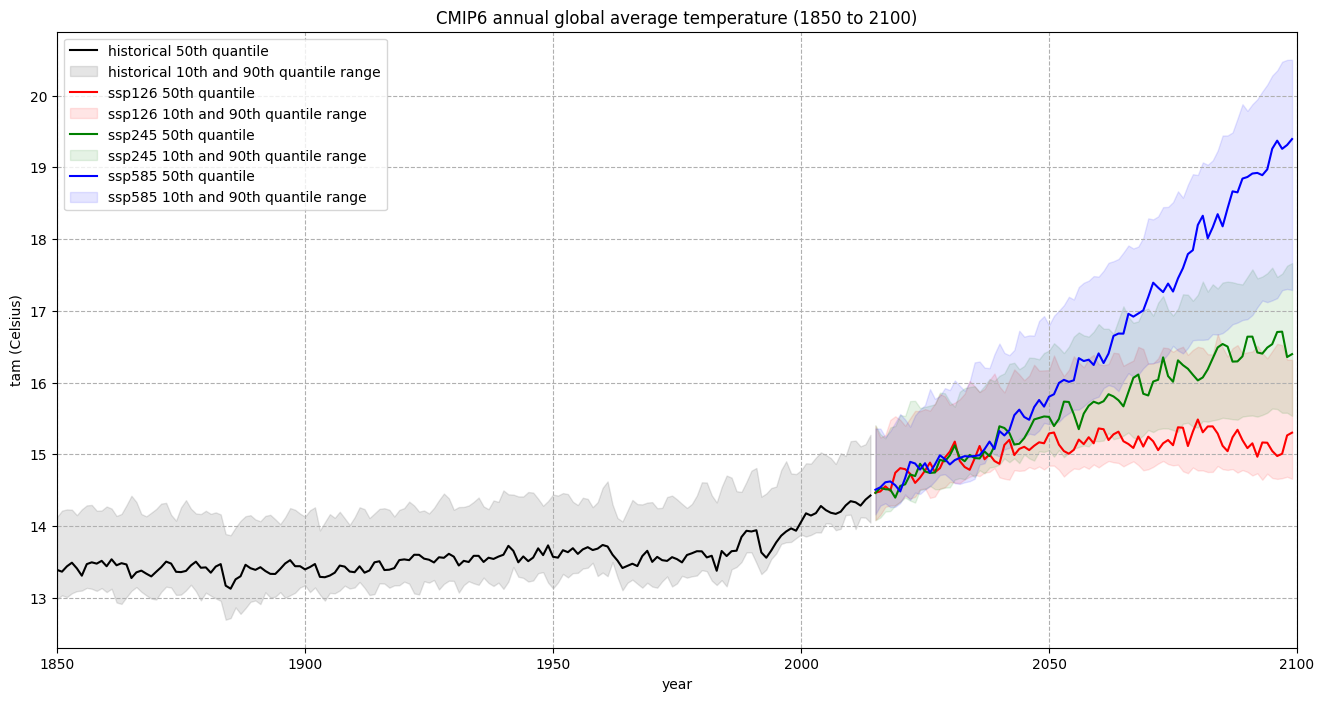

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['black','red','green','blue']
for i in np.arange(len(experiments)):
    ax.plot(data_50.year, data_50[i,:], color=f'{colours[i]}',
            label=f'{data_50.experiment[i].values} 50th quantile')
    ax.fill_between(data_50.year, data_90[i,:], data_10[i,:], alpha=0.1, color=f'{colours[i]}',
            label=f'{data_50.experiment[i].values} 10th and 90th quantile range')

ax.set_xlim(1850,2100)
ax.set_title('CMIP6 annual global average temperature (1850 to 2100)')
ax.set_ylabel('tam (Celsius)')
ax.set_xlabel('year')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

fig.savefig(f'{DATADIR}CMIP6_annual_global_tas.png')

The visualization of the `CMIP6 annual global average temperature (1850 to 2100)` above shows that the global average temperature was more or less stable in the pre-industrial phase, but steadily increases since the 1990s. It shows further that, depending on the SSP scenario, the course and increase of the global annual temperature differs. While for the best case `SSP1-2.6` scenario, the global annual temperature could stabilize around 15 degC, in the worst case `SSP5-8.5` scenario, the global annual temperature could increase to above 20 degC.

<hr>

<p></p>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>